Using ILP backend: ortools
Starting exact VCG federated learning simulation...
Generating synthetic data ...
Initial RMSE (test): 2.0147

--- Round 1/8 ---
ILP solved in 0.16s; candidates=30; winners_count=27
Round 1: RMSE before = 2.0147 | sum(utilities) = 23.261768
Winners: 27 | VCG payment this round = 63.04 | (detailed below)
  - Client 0: declared_value=9.616899, declared_cost=1.625179, vcg_payment=2.54, utility=0.916502
  - Client 3: declared_value=7.597764, declared_cost=1.558081, vcg_payment=2.54, utility=0.983600
  - Client 4: declared_value=5.602659, declared_cost=1.227415, vcg_payment=1.53, utility=0.300488
  - Client 11: declared_value=8.274888, declared_cost=1.656915, vcg_payment=2.54, utility=0.884765
  - Client 13: declared_value=8.921228, declared_cost=1.523544, vcg_payment=2.37, utility=0.842182
  - Client 14: declared_value=5.299969, declared_cost=0.983104, vcg_payment=1.35, utility=0.368845
  - Client 17: declared_value=7.961907, declared_cost=1.586582, vcg_payment=2

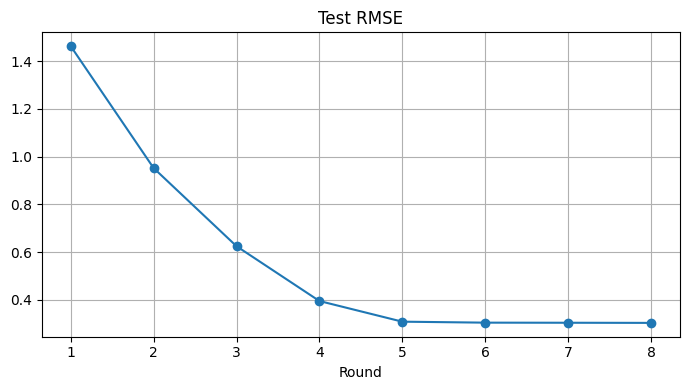

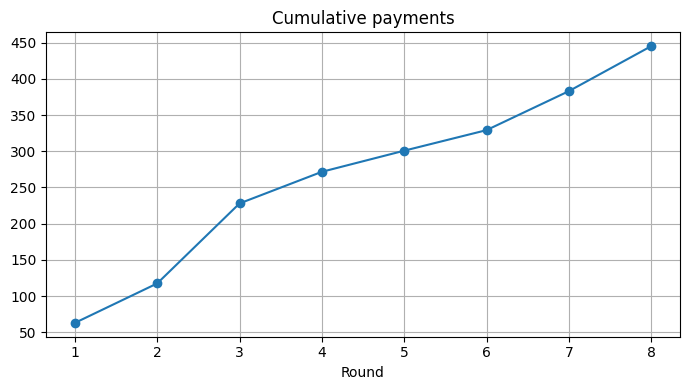

In [7]:
#!/usr/bin/env python3
"""
fl_vcg_exact_ilp.py

Federated Learning + exact VCG (ILP) auction + optional MovieLens loader.

Features:
 - Neural Collaborative Filtering (PyTorch)
 - FedAvg aggregation of winning clients
 - Exact knapsack (WDP) solved with ILP (OR-Tools preferred, falls back to PuLP)
 - Exact VCG (Clarke pivot) payments by re-solving ILP without each winner
 - Optional MovieLens 100k / 1M download & loader (use with --use-movielens)

Usage examples:
  python fl_vcg_exact_ilp.py --use-movielens --ml-dataset 100k --rounds 8 --candidate-pool-size 30
  python fl_vcg_exact_ilp.py --rounds 6 --use-sim
"""
import os
import sys
import math
import time
import json
import random
import argparse
import datetime
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Try to import PyTorch
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    TORCH = True
except Exception as e:
    TORCH = False
    print("PyTorch not found. Please `pip install torch` to run the full script.", file=sys.stderr)

# Try to import OR-Tools (recommended) or PuLP
ILP_BACKEND = None
try:
    from ortools.linear_solver import pywraplp
    ILP_BACKEND = 'ortools'
except Exception:
    try:
        import pulp
        ILP_BACKEND = 'pulp'
    except Exception:
        ILP_BACKEND = None

if ILP_BACKEND is None:
    print("WARNING: No ILP solver found. Install ortools (`pip install ortools`) or pulp (`pip install pulp`).", file=sys.stderr)

# -------------------------
# Hyperparameters & config
# -------------------------
RNG = 42
random.seed(RNG)
np.random.seed(RNG)
if TORCH:
    torch.manual_seed(RNG)

OUT_DIR = "./fl_vcg_exact_out"
os.makedirs(OUT_DIR, exist_ok=True)

# Default simulation params (can be overridden via CLI)
SIM_NUM_CLIENTS = 100
SIM_NUM_ITEMS = 500
SIM_TRUE_EMB_SIZE = 10
SIM_RATINGS_PER_CLIENT = 200
SIM_TEST_RATINGS = 5000

GLOBAL_BUDGET_PER_ROUND = 40.0
NUM_ROUNDS = 10
CLIENTS_PER_ROUND_TARGET = 15
LOCAL_EPOCHS = 1
LOCAL_LR = 0.01
BATCH_SIZE = 32

# -------------------------
# MovieLens loader (100k / 1M)
# -------------------------
def download_and_extract_movielens(target='100k', data_dir='./data'):
    """
    Downloads MovieLens 100k or 1M into data_dir and returns base path.
    """
    import zipfile, urllib.request, tarfile
    os.makedirs(data_dir, exist_ok=True)
    if target == '100k':
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        dest_zip = os.path.join(data_dir, "ml-100k.zip")
        extract_dir = os.path.join(data_dir, "ml-100k")
        if os.path.isdir(extract_dir):
            return extract_dir
        print("Downloading MovieLens 100k...")
        urllib.request.urlretrieve(url, dest_zip)
        print("Extracting...")
        with zipfile.ZipFile(dest_zip, 'r') as zf:
            zf.extractall(data_dir)
        return extract_dir
    elif target == '1M':
        url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
        dest_zip = os.path.join(data_dir, "ml-1m.zip")
        extract_dir = os.path.join(data_dir, "ml-1m")
        if os.path.isdir(extract_dir):
            return extract_dir
        print("Downloading MovieLens 1M (may be larger)...")
        urllib.urlretrieve(url, dest_zip) # Using urllib.request for Python 3
        print("Extracting...")
        with zipfile.ZipFile(dest_zip, 'r') as zf:
            zf.extractall(data_dir)
        return extract_dir
    else:
        raise ValueError("target must be '100k' or '1M'")

def load_movielens(dataset='100k', data_dir='./data', sample_users=None):
    """
    Loads MovieLens ratings into per-user partitions.
    Returns: client_datasets (dict user_id -> pandas DF) and server_val_df, server_test_df
    If sample_users provided, limits to a subset (useful for speed).
    """
    base = download_and_extract_movielens(dataset, data_dir)
    if dataset == '100k':
        data_file = os.path.join(base, 'u.data')
        # Format: user id | item id | rating | timestamp (tab-separated)
        cols = ['user_id', 'movie_id', 'rating', 'ts']
        df = pd.read_csv(data_file, sep='\t', names=cols, engine='python')
    else:  # 1M
        data_file = os.path.join(base, 'ratings.dat')
        # Format: UserID::MovieID::Rating::Timestamp
        cols = ['user_id', 'movie_id', 'rating', 'ts']
        df = pd.read_csv(data_file, sep='::', names=cols, engine='python', encoding='latin-1')

    # zero-index user ids and movie ids
    df['user_id'] = df['user_id'].astype(int) - 1
    df['movie_id'] = df['movie_id'].astype(int) - 1
    df['rating'] = df['rating'].astype(float)

    # optional user sampling
    if sample_users is not None:
        users = df['user_id'].unique()
        chosen = np.random.choice(users, size=sample_users, replace=False)
        df = df[df['user_id'].isin(chosen)]

    # build per-user partitions (train 80 / val 10 / test 10 per user)
    per_user = {}
    server_val = []
    server_test = []
    for u, g in df.groupby('user_id'):
        records = g[['user_id', 'movie_id', 'rating']].values.tolist()
        random.shuffle(records)
        n = len(records)
        n_train = max(1, int(0.8 * n))
        n_val = max(1, int(0.1 * n))
        train = records[:n_train]
        val = records[n_train:n_train+n_val]
        test = records[n_train+n_val:]
        per_user[int(u)] = pd.DataFrame(train, columns=['user_id', 'movie_id', 'rating'])
        server_val += val
        server_test += test
    server_val_df = pd.DataFrame(server_val, columns=['user_id', 'movie_id', 'rating'])
    server_test_df = pd.DataFrame(server_test, columns=['user_id', 'movie_id', 'rating'])
    return per_user, server_val_df, server_test_df

# -------------------------
# Synthetic data generator
# -------------------------
def generate_synthetic(num_clients=SIM_NUM_CLIENTS, num_items=SIM_NUM_ITEMS, true_emb_size=SIM_TRUE_EMB_SIZE,
                       ratings_per_client=SIM_RATINGS_PER_CLIENT, test_ratings=SIM_TEST_RATINGS):
    true_user_emb = np.random.rand(num_clients, true_emb_size)
    true_item_emb = np.random.rand(num_items, true_emb_size)
    client_datasets = {}
    for u in range(num_clients):
        client_data = []
        num_ratings = int(ratings_per_client * (np.random.rand() * 1.5 + 0.5))
        for _ in range(num_ratings):
            i = np.random.randint(0, num_items)
            dot = np.dot(true_user_emb[u], true_item_emb[i])
            rating = (dot / true_emb_size) * 4 + 1 + np.random.normal(0, 0.5)
            rating = float(np.clip(rating, 1.0, 5.0))
            client_data.append([u, i, rating])
        client_datasets[u] = pd.DataFrame(client_data, columns=['user_id', 'movie_id', 'rating'])

    test_data = []
    for _ in range(test_ratings):
        u = np.random.randint(0, num_clients)
        i = np.random.randint(0, num_items)
        dot = np.dot(true_user_emb[u], true_item_emb[i])
        rating = float(np.clip((dot / true_emb_size) * 4 + 1, 1.0, 5.0))
        test_data.append([u, i, rating])
    test_df = pd.DataFrame(test_data, columns=['user_id', 'movie_id', 'rating'])
    return client_datasets, test_df

# -------------------------
# PyTorch model (NCF)
# -------------------------
if TORCH:
    class NeuralCollaborativeFiltering(nn.Module):
        def __init__(self, num_users, num_items, gmf_emb_size=16, mlp_emb_size=16, mlp_layers=[32, 16]):
            super().__init__()
            self.num_users = num_users
            self.num_items = num_items
            self.emb_gmf_user = nn.Embedding(num_users, gmf_emb_size)
            self.emb_gmf_item = nn.Embedding(num_items, gmf_emb_size)
            self.emb_mlp_user = nn.Embedding(num_users, mlp_emb_size)
            self.emb_mlp_item = nn.Embedding(num_items, mlp_emb_size)
            mlp_input = mlp_emb_size * 2
            layers = []
            for sz in mlp_layers:
                layers.append(nn.Linear(mlp_input, sz)); layers.append(nn.ReLU()); mlp_input = sz
            self.mlp = nn.Sequential(*layers)
            self.predict = nn.Linear(gmf_emb_size + mlp_layers[-1], 1)
            self._init_weights()
        def _init_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Embedding):
                    nn.init.xavier_uniform_(m.weight)
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)
        def forward(self, users, items):
            g_u = self.emb_gmf_user(users); g_i = self.emb_gmf_item(items); g = g_u * g_i
            m_u = self.emb_mlp_user(users); m_i = self.emb_mlp_item(items)
            m = torch.cat([m_u, m_i], dim=-1); m = self.mlp(m)
            v = torch.cat([g, m], dim=-1)
            out = self.predict(v).squeeze(-1)
            return out
    class MovieLensClientDataset(Dataset):
        def __init__(self, df):
            self.users = torch.tensor(df['user_id'].values, dtype=torch.long)
            self.items = torch.tensor(df['movie_id'].values, dtype=torch.long)
            self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)
        def __len__(self):
            return len(self.ratings)
        def __getitem__(self, idx):
            return self.users[idx], self.items[idx], self.ratings[idx]

# -------------------------
# Client local training & server aggregation
# -------------------------
def client_local_train(global_model, client_df, local_epochs=LOCAL_EPOCHS, lr=LOCAL_LR, batch_size=BATCH_SIZE):
    if not TORCH:
        raise RuntimeError("Torch required.")
    local_model = NeuralCollaborativeFiltering(global_model.num_users, global_model.num_items)
    local_model.load_state_dict(global_model.state_dict())
    local_model.train()
    if len(client_df) == 0:
        return local_model.state_dict()
    ds = MovieLensClientDataset(client_df); dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    opt = optim.SGD(local_model.parameters(), lr=lr); loss_fn = nn.MSELoss()
    for _ in range(local_epochs):
        for u,i,r in dl:
            opt.zero_grad(); preds = local_model(u,i); loss = loss_fn(preds, r); loss.backward(); opt.step()
    return local_model.state_dict()

def server_fedavg_aggregate(global_model, client_updates, client_sizes):
    if not TORCH:
        raise RuntimeError("Torch required.")
    global_state = global_model.state_dict()
    new_state = OrderedDict()
    total = float(sum(client_sizes.values())) if sum(client_sizes.values())>0 else 1.0
    # init zeros
    for k,v in global_state.items():
        new_state[k] = torch.zeros_like(v)
    for cid, st in client_updates.items():
        w = float(client_sizes[cid]) / total if total>0 else 0.0
        for k in st.keys():
            new_state[k] += st[k].float() * w
    # load
    global_model.load_state_dict(new_state)
    return global_model

# -------------------------
# Evaluation
# -------------------------
def evaluate_rmse(model, test_df, batch_size=256):
    if not TORCH: raise RuntimeError("Torch required.")
    model.eval()
    ds = MovieLensClientDataset(test_df); dl = DataLoader(ds, batch_size=batch_size)
    total = 0.0; n = 0
    loss_fn = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        for u,i,r in dl:
            preds = model(u,i)
            total += float(loss_fn(preds, r))
            n += u.size(0)
    mse = total / n if n>0 else float('nan')
    return math.sqrt(mse)

# -------------------------
# Exact knapsack ILP (WDP) implementations
# -------------------------
def solve_knapsack_ilp(bids, budget, backend_hint=ILP_BACKEND, time_limit_seconds=30):
    cids = list(bids.keys())
    values = {cid: float(bids[cid][0]) for cid in cids}
    costs = {cid: float(bids[cid][1]) for cid in cids}

    if backend_hint == 'ortools':
        solver = pywraplp.Solver.CreateSolver('CBC')
        if solver is None:
            raise RuntimeError("ORTools CBC solver not available.")
        x = {cid: solver.IntVar(0, 1, f"x_{cid}") for cid in cids}
        # objective
        obj = solver.Objective()
        for cid in cids:
            obj.SetCoefficient(x[cid], values[cid])
        obj.SetMaximization()
        # budget constraint
        cons = solver.RowConstraint(-solver.infinity(), budget, 'budget')
        for cid in cids:
            cons.SetCoefficient(x[cid], costs[cid])
        if time_limit_seconds:
            solver.SetTimeLimit(int(time_limit_seconds * 1000))
        status = solver.Solve()
        if status not in (pywraplp.Solver.OPTIMAL, pywraplp.Solver.FEASIBLE):
            return set(), 0.0
        winners = set(cid for cid in cids if x[cid].solution_value() > 0.5)
        total_value = sum(values[c] for c in winners)
        return winners, total_value

    elif backend_hint == 'pulp':
        prob = pulp.LpProblem("knapsack", pulp.LpMaximize)
        x = {cid: pulp.LpVariable(f"x_{cid}", cat='Binary') for cid in cids}
        prob += pulp.lpSum([values[cid] * x[cid] for cid in cids])
        prob += pulp.lpSum([costs[cid] * x[cid] for cid in cids]) <= budget
        prob.solve(pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit_seconds))
        winners = set(cid for cid in cids if pulp.value(x[cid]) is not None and pulp.value(x[cid]) > 0.5)
        total_value = sum(values[c] for c in winners)
        return winners, total_value

    else:
        raise RuntimeError("No ILP solver backend available. Install ortools or pulp.")

# -------------------------
# Exact VCG payments via re-solving ILP (Clarke pivot)
# -------------------------
def compute_vcg_payments_ilp(bids, budget, solver_backend=ILP_BACKEND, time_limit_seconds=30):
    if solver_backend is None:
        raise RuntimeError("No ILP backend available for exact VCG.")
    S_star, V_star = solve_knapsack_ilp(bids, budget, backend_hint=solver_backend, time_limit_seconds=time_limit_seconds)
    if not S_star:
        return set(), {}
    payments = {}
    for i in S_star:
        bids_wo = {k: v for k, v in bids.items() if k != i}
        S_minus, V_minus = solve_knapsack_ilp(bids_wo, budget, backend_hint=solver_backend, time_limit_seconds=time_limit_seconds)
        V_others_with_i = V_star - bids[i][0]
        payment_i = V_minus - V_others_with_i
        payments[i] = float(payment_i)
    final_payments = {cid: p for cid, p in payments.items() if p >= bids[cid][1]}
    final_winners = set(final_payments.keys())
    return final_winners, final_payments

# -------------------------
# Main experiment pipeline (with utilities + final payment prints)
# -------------------------
def run_experiment(use_movielens=False, ml_dataset='100k', sample_users=None, candidate_pool_size=30,
                   rounds=NUM_ROUNDS, budget=GLOBAL_BUDGET_PER_ROUND, verbose=True, ilp_time_limit=30.0):
    if not TORCH:
        raise RuntimeError("PyTorch required. Install it and try again.")

    # Load data
    if use_movielens:
        if verbose: print(f"Loading MovieLens {ml_dataset} ...")
        client_datasets, server_val_df, server_test_df = load_movielens(ml_dataset, data_dir='./data', sample_users=sample_users)
    else:
        if verbose: print("Generating synthetic data ...")
        client_datasets, server_test_df = generate_synthetic()
        server_val_df = server_test_df.sample(n=min(1000, len(server_test_df)), random_state=RNG).reset_index(drop=True)

    client_ids = list(client_datasets.keys())

    max_user = max([df['user_id'].max() if len(df)>0 else 0 for df in client_datasets.values()] + [server_test_df['user_id'].max()])
    max_item = max([df['movie_id'].max() if len(df)>0 else 0 for df in client_datasets.values()] + [server_test_df['movie_id'].max()])
    num_users = int(max_user) + 1
    num_items = int(max_item) + 1

    model = NeuralCollaborativeFiltering(num_users, num_items)
    initial_rmse = evaluate_rmse(model, server_test_df)
    if verbose: print(f"Initial RMSE (test): {initial_rmse:.4f}")

    history = []
    cumulative_payments = 0.0

    for rnd in range(1, rounds+1):
        print(f"\n--- Round {rnd}/{rounds} ---")
        # Evaluate RMSE before the round (before any updates)
        rmse_before = evaluate_rmse(model, server_test_df)

        # Build candidate pool
        candidate_pool = random.sample(client_ids, min(candidate_pool_size, len(client_ids)))

        # Build bids (v_i,value ; c_i,cost)
        bids = {}
        for cid in candidate_pool:
            df = client_datasets[cid]
            c_i = (len(df) * 0.005) + np.random.rand() * 0.5 + 0.05
            data_var = df['rating'].var() if len(df) > 1 else 0.0
            data_var_norm = (data_var - 1.0) / 4.0
            v_i = (len(df) / SIM_RATINGS_PER_CLIENT) + data_var_norm
            v_i = v_i * (CLIENTS_PER_ROUND_TARGET / 2.0)
            if np.random.rand() < 0.25:
                v_i = c_i + np.random.rand() * 2.0
            bids[cid] = (float(v_i), float(c_i))

        # Solve exact VCG (ILP)
        start_time = time.time()
        winners, payments = compute_vcg_payments_ilp(bids, budget, solver_backend=ILP_BACKEND, time_limit_seconds=ilp_time_limit)
        elapsed = time.time() - start_time
        print(f"ILP solved in {elapsed:.2f}s; candidates={len(candidate_pool)}; winners_count={len(winners)}")

        if not winners:
            print(f"Round {rnd}: No winners (IR filter or infeasible). RMSE before = {rmse_before:.4f}")
            history.append({'round': rnd, 'winners': [], 'payment': 0.0, 'cumulative': cumulative_payments, 'rmse': rmse_before})
            continue

        # Compute utilities = payment - cost for each winner (VCG profit)
        utilities = {}
        for wid, pay in payments.items():
            cost = bids[wid][1]
            utilities[wid] = float(pay) - float(cost)
        sum_utilities = sum(utilities.values())

        # Print RMSE before and sum(utilities)
        print(f"Round {rnd}: RMSE before = {rmse_before:.4f} | sum(utilities) = {sum_utilities:.6f}")

        # Print winners & per-winner breakdown: value, cost, payment, utility
        winners_sorted = sorted(winners)
        print(f"Winners: {len(winners_sorted)} | VCG payment this round = {sum(payments.values()):.2f} | (detailed below)")
        for wid in winners_sorted:
            v, c = bids[wid]
            p = payments.get(wid, 0.0)
            u = utilities.get(wid, None)
            print(f"  - Client {wid}: declared_value={v:.6f}, declared_cost={c:.6f}, vcg_payment={p:.2f}, utility={u:.6f}")

        # Show top-5 losing bidders by value/cost ratio for debugging
        losers = [cid for cid in candidate_pool if cid not in winners]
        if losers:
            losers_sorted = sorted(losers, key=lambda x: (bids[x][0] / (bids[x][1] if bids[x][1] > 0 else 1e-9)), reverse=True)
            top_losers = losers_sorted[:5]
            print("Top losing bidders (by value/cost):")
            for lid in top_losers:
                v,c = bids[lid]
                ratio = v / (c if c>0 else 1e-9)
                print(f"   - Client {lid}: value={v:.6f}, cost={c:.6f}, ratio={ratio:.6f}")

        # Local training for winners
        client_updates = {}
        client_sizes = {}
        for cid in winners:
            local_df = client_datasets[cid]
            updated_state = client_local_train(model, local_df, local_epochs=LOCAL_EPOCHS, lr=LOCAL_LR, batch_size=BATCH_SIZE)
            client_updates[cid] = updated_state
            client_sizes[cid] = len(local_df)

        # Aggregate winners updates
        model = server_fedavg_aggregate(model, client_updates, client_sizes)

        # Payments and RMSE after
        payment_round = sum(payments.values())
        cumulative_payments += payment_round
        rmse_after = evaluate_rmse(model, server_test_df)

        print(f"VCG payment this round = {payment_round:.2f} | RMSE after = {rmse_after:.4f}")
        print(f"Round {rnd} summary: winners={len(winners_sorted)}, payment_round={payment_round:.2f}, cumulative={cumulative_payments:.2f}, test_rmse={rmse_after:.4f}")

        history.append({'round': rnd, 'winners': winners_sorted, 'payment': payment_round, 'cumulative': cumulative_payments, 'rmse': rmse_after, 'sum_utilities': sum_utilities})

    # Final summary
    final_rmse = evaluate_rmse(model, server_test_df)
    print(f"\nDone. Final test RMSE = {final_rmse:.4f}. Total payments = {cumulative_payments:.2f}")

    # Save results
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    outpath = os.path.join(OUT_DIR, f"fl_vcg_exact_{now}.json")
    with open(outpath, "w") as f:
        json.dump({'history': history, 'initial_rmse': initial_rmse, 'final_rmse': final_rmse, 'cumulative_payments': cumulative_payments}, f, indent=2)
    print(f"Saved history to {outpath}")

    # Plots
    rounds_list = [h['round'] for h in history]
    rmses = [h['rmse'] for h in history]
    cumulative = [h['cumulative'] for h in history]
    if rounds_list:
        plt.figure(figsize=(7,4)); plt.plot(rounds_list, rmses, marker='o'); plt.title("Test RMSE"); plt.xlabel("Round"); plt.grid(True); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "rmse.png")); plt.show()
        plt.figure(figsize=(7,4)); plt.plot(rounds_list, cumulative, marker='o'); plt.title("Cumulative payments"); plt.xlabel("Round"); plt.grid(True); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "payments.png")); plt.show()

    return history

# -------------------------
# Colab-specific execution
# -------------------------
# Install ortools as it's a common dependency and often not pre-installed
!pip install ortools

# Set parameters directly for Colab execution
# These correspond to the default values in the original argparse setup,
# but can be changed as needed.
use_movielens = False
ml_dataset = '100k'
sample_users = None
candidate_pool_size = 30
rounds = 8
budget = GLOBAL_BUDGET_PER_ROUND # Using the global variable defined earlier
local_epochs = LOCAL_EPOCHS # Using the global variable defined earlier
time_limit_ilp = 30.0

# Re-check ILP_BACKEND after installation
ILP_BACKEND = None
try:
    from ortools.linear_solver import pywraplp
    ILP_BACKEND = 'ortools'
except Exception:
    try:
        import pulp
        ILP_BACKEND = 'pulp'
    except Exception:
        ILP_BACKEND = None

if ILP_BACKEND is None:
    print("Error: No ILP backend available even after installation attempt. Please check your environment.", file=sys.stderr)
else:
    print(f"Using ILP backend: {ILP_BACKEND}")

# Run the experiment
print("Starting exact VCG federated learning simulation...")
history_exact = run_experiment(use_movielens=use_movielens, ml_dataset=ml_dataset, sample_users=sample_users,
                               candidate_pool_size=candidate_pool_size, rounds=rounds, budget=budget, ilp_time_limit=time_limit_ilp)
